In [1]:
import rospy
import tf
from nav_msgs.msg import Path
from nav_msgs.msg import Odometry
from tf.transformations import euler_from_quaternion, quaternion_from_euler
from PythonRobotics.PathPlanning.CubicSpline import cubic_spline_planner
import scipy.linalg as la
import matplotlib.pyplot as plt
import math
import numpy as np
import sys
import os
from geometry_msgs.msg import Twist

In [7]:

Kp = 1.0  # speed proportional gain

# LQR parameter
Q = np.eye(4)
R = np.eye(1)

# parameters
dt = 0.1  # time tick[s]
L = 0.5  # Wheel base of the vehicle [m]
max_steer = np.deg2rad(55.0)  # maximum steering angle[rad]

show_animation = True
#  show_animation = False


class State:

    def __init__(self, x=0.0, y=0.0, yaw=0.0, v=0.0):
        self.x = x
        self.y = y
        self.yaw = yaw
        self.v = v


def update(state, a, delta):

    if delta >= max_steer:
        delta = max_steer
    if delta <= - max_steer:
        delta = - max_steer

    state.x = state.x + state.v * math.cos(state.yaw) * dt
    state.y = state.y + state.v * math.sin(state.yaw) * dt
    state.yaw = state.yaw + state.v / L * math.tan(delta) * dt
    state.v = state.v + a * dt

    return state


def PIDControl(target, current):
    a = Kp * (target - current)

    return a


def pi_2_pi(angle):
    return (angle + math.pi) % (2 * math.pi) - math.pi


def solve_DARE(A, B, Q, R):
    """
    solve a discrete time_Algebraic Riccati equation (DARE)
    """
    X = Q
    maxiter = 150
    eps = 0.01

    for i in range(maxiter):
        Xn = A.T @ X @ A - A.T @ X @ B @ \
            la.inv(R + B.T @ X @ B) @ B.T @ X @ A + Q
        if (abs(Xn - X)).max() < eps:
            break
        X = Xn

    return Xn


def dlqr(A, B, Q, R):
    """Solve the discrete time lqr controller.
    x[k+1] = A x[k] + B u[k]
    cost = sum x[k].T*Q*x[k] + u[k].T*R*u[k]
    # ref Bertsekas, p.151
    """

    # first, try to solve the ricatti equation
    X = solve_DARE(A, B, Q, R)

    # compute the LQR gain
    K = la.inv(B.T @ X @ B + R) @ (B.T @ X @ A)

    eigVals, eigVecs = la.eig(A - B @ K)

    return K, X, eigVals


def lqr_steering_control(state, cx, cy, cyaw, ck, pe, pth_e):
    ind, e = calc_nearest_index(state, cx, cy, cyaw)

    k = ck[ind]
    v = state.v
    th_e = pi_2_pi(state.yaw - cyaw[ind])

    A = np.zeros((4, 4))
    A[0, 0] = 1.0
    A[0, 1] = dt
    A[1, 2] = v
    A[2, 2] = 1.0
    A[2, 3] = dt
    # print(A)

    B = np.zeros((4, 1))
    B[3, 0] = v / L

    K, _, _ = dlqr(A, B, Q, R)

    x = np.zeros((4, 1))

    x[0, 0] = e
    x[1, 0] = (e - pe) / dt
    x[2, 0] = th_e
    x[3, 0] = (th_e - pth_e) / dt

    ff = math.atan2(L * k, 1)
    fb = pi_2_pi((-K @ x)[0, 0])

    delta = ff + fb

    return delta, ind, e, th_e


def calc_nearest_index(state, cx, cy, cyaw):
    dx = [state.x - icx for icx in cx]
    dy = [state.y - icy for icy in cy]

    d = [idx ** 2 + idy ** 2 for (idx, idy) in zip(dx, dy)]

    mind = min(d)

    ind = d.index(mind)

    mind = math.sqrt(mind)

    dxl = cx[ind] - state.x
    dyl = cy[ind] - state.y

    angle = pi_2_pi(cyaw[ind] - math.atan2(dyl, dxl))
    if angle < 0:
        mind *= -1

    return ind, mind


def closed_loop_prediction(cx, cy, cyaw, ck, speed_profile, goal):
    T = 25.0  # max simulation time
    goal_dis = 0.3
    stop_speed = 0.05

    state = State(x=-0.0, y=-0.0, yaw=0.0, v=0.0)

    time = 0.0
    x = [state.x]
    y = [state.y]
    yaw = [state.yaw]
    v = [state.v]
    t = [0.0]

    e, e_th = 0.0, 0.0

    while T >= time:
        dl, target_ind, e, e_th = lqr_steering_control(
            state, cx, cy, cyaw, ck, e, e_th)

        ai = PIDControl(speed_profile[target_ind], state.v)
        state = update(state, ai, dl)

        if abs(state.v) <= stop_speed:
            target_ind += 1

        time = time + dt

        # check goal
        dx = state.x - goal[0]
        dy = state.y - goal[1]
        if math.hypot(dx, dy) <= goal_dis:
            print("Goal")
            break

        x.append(state.x)
        y.append(state.y)
        yaw.append(state.yaw)
        v.append(state.v)
        t.append(time)

        if target_ind % 1 == 0 and show_animation:
            plt.cla()
            # for stopping simulation with the esc key.
            plt.gcf().canvas.mpl_connect('key_release_event',
                    lambda event: [exit(0) if event.key == 'escape' else None])
            plt.plot(cx, cy, "-r", label="course")
            plt.plot(x, y, "ob", label="trajectory")
            plt.plot(cx[target_ind], cy[target_ind], "xg", label="target")
            plt.axis("equal")
            plt.grid(True)
            plt.title("speed[km/h]:" + str(round(state.v * 3.6, 2))
                      + ",target index:" + str(target_ind))
            plt.pause(0.0001)

    return t, x, y, yaw, v


def calc_speed_profile(cx, cy, cyaw, target_speed):
    speed_profile = [target_speed] * len(cx)

    direction = 1.0

    # Set stop point
    for i in range(len(cx) - 1):
        dyaw = abs(cyaw[i + 1] - cyaw[i])
        switch = math.pi / 4.0 <= dyaw < math.pi / 2.0

        if switch:
            direction *= -1

        if direction != 1.0:
            speed_profile[i] = - target_speed
        else:
            speed_profile[i] = target_speed

        if switch:
            speed_profile[i] = 0.0

    speed_profile[-1] = 0.0

    return speed_profile

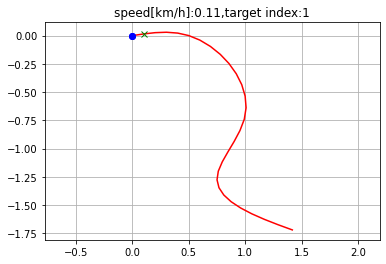

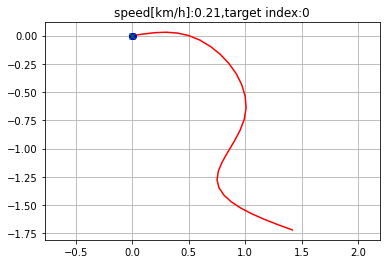

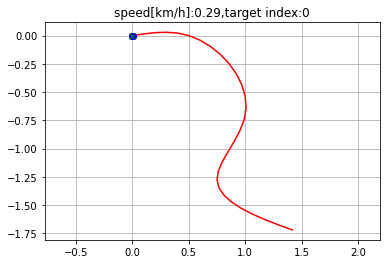

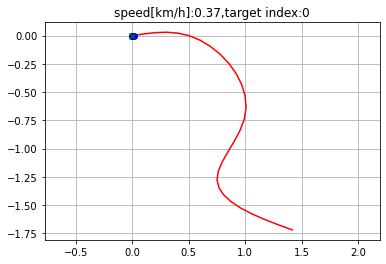

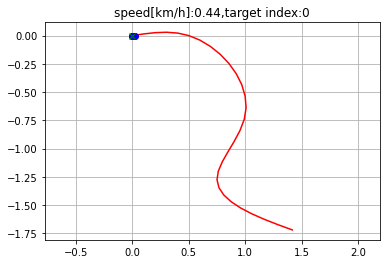

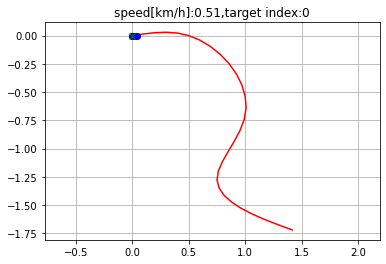

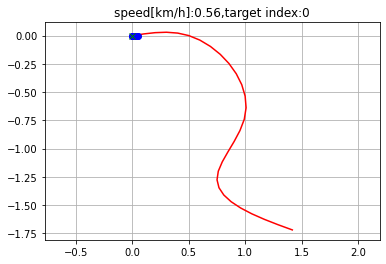

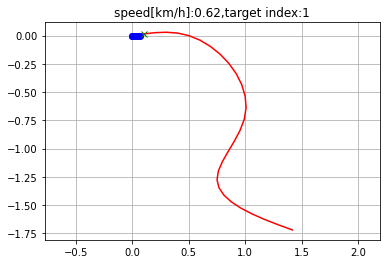

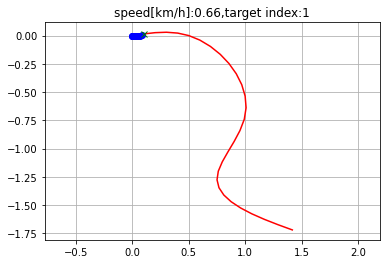

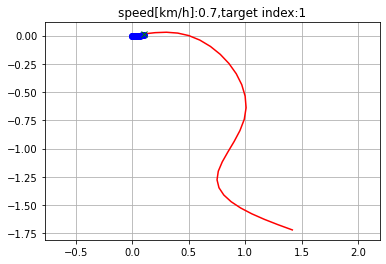

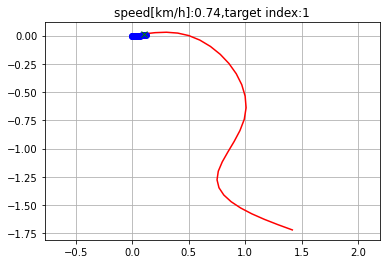

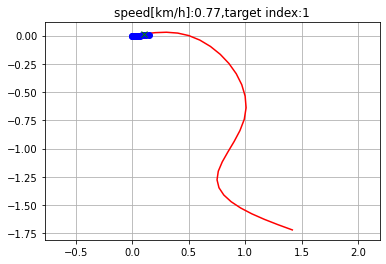

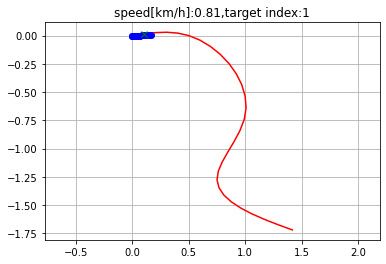

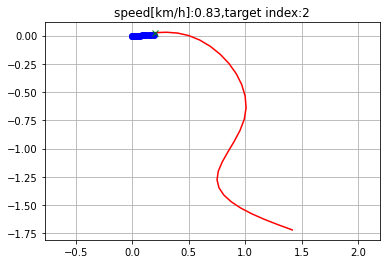

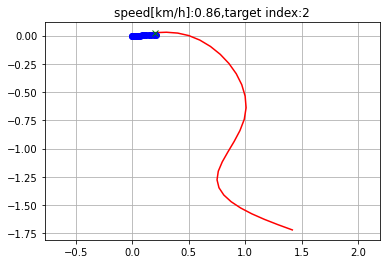

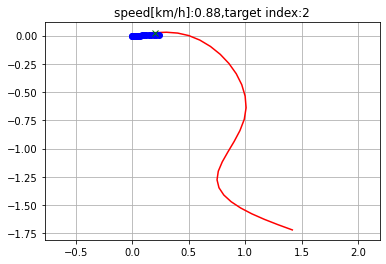

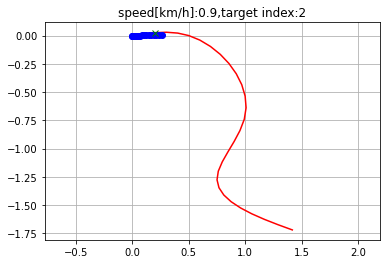

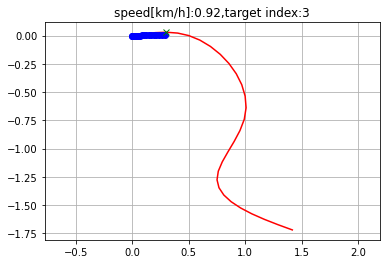

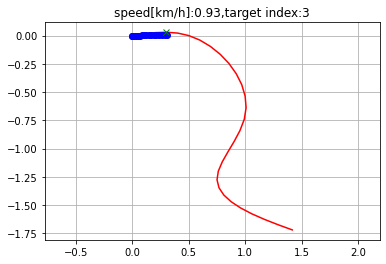

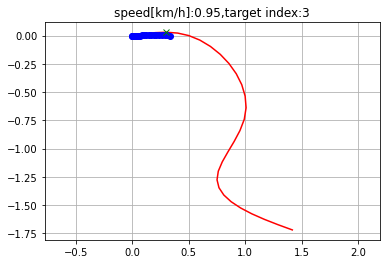

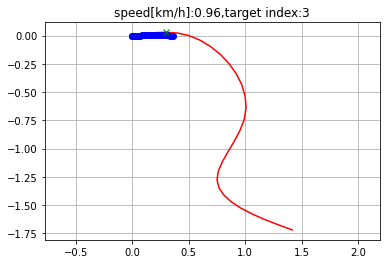

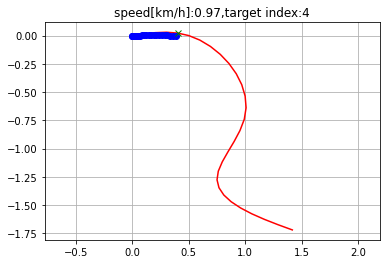

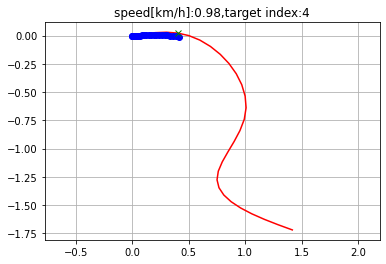

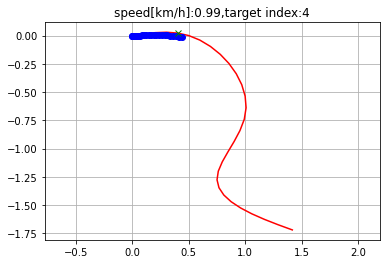

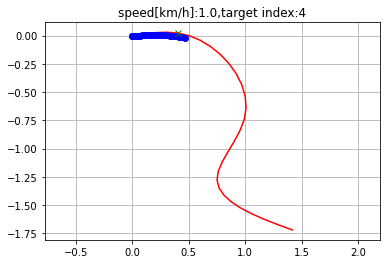

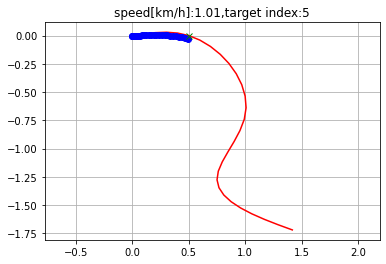

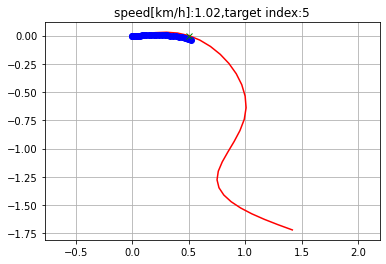

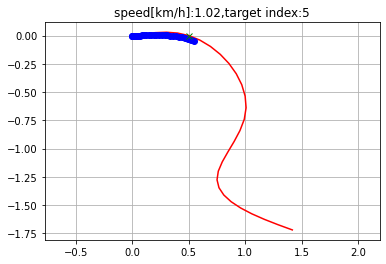

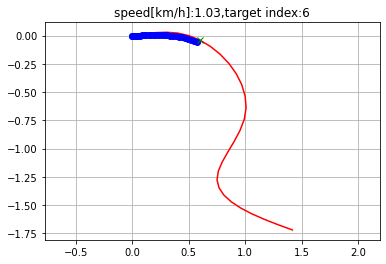

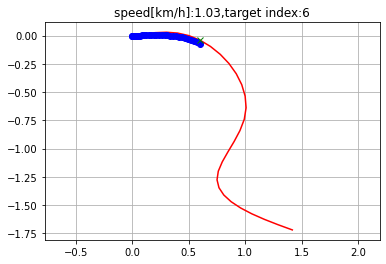

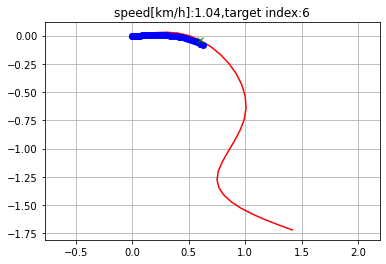

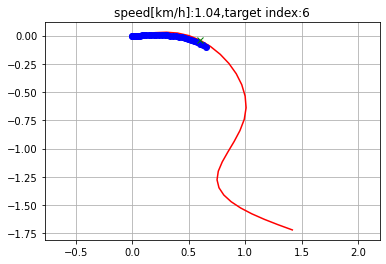

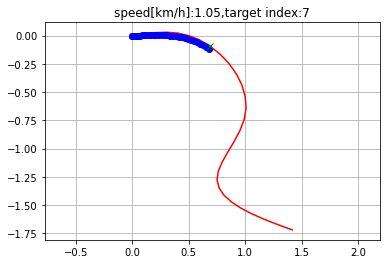

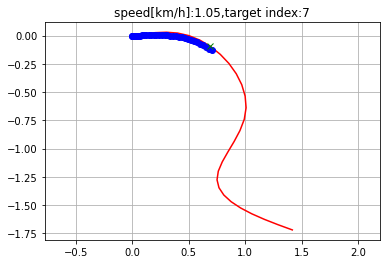

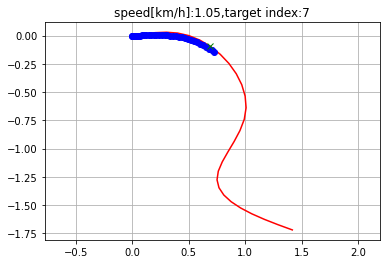

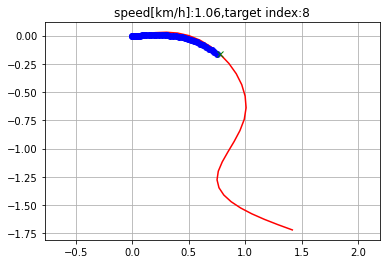

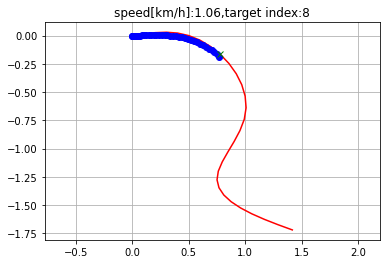

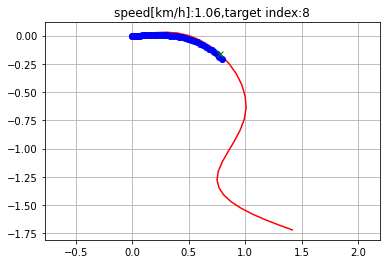

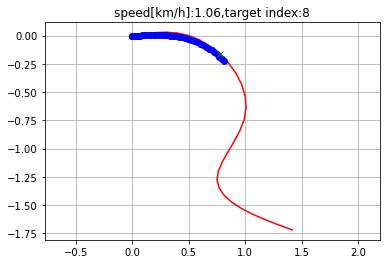

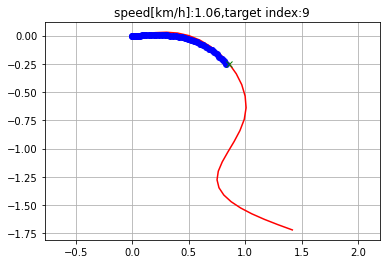

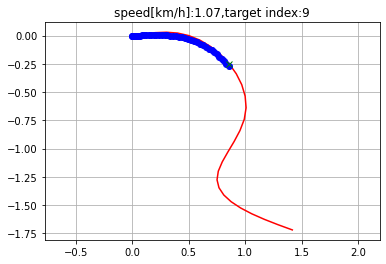

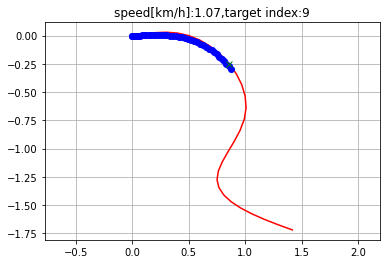

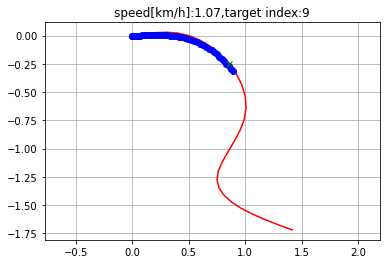

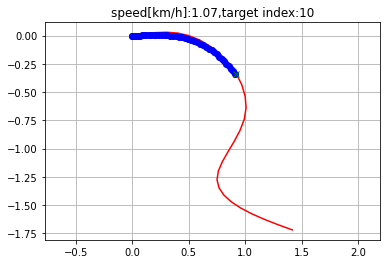

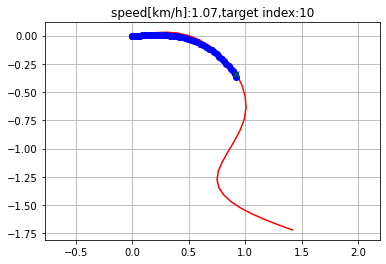

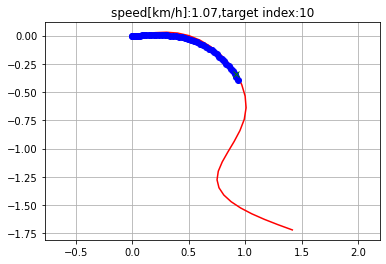

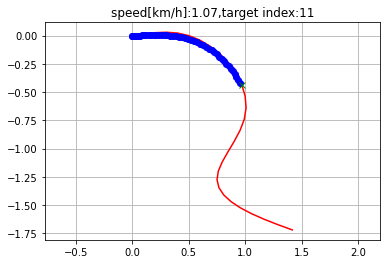

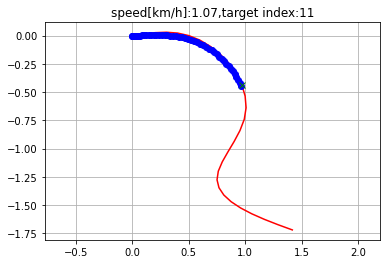

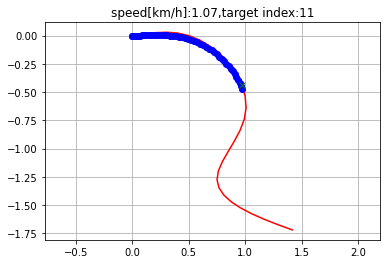

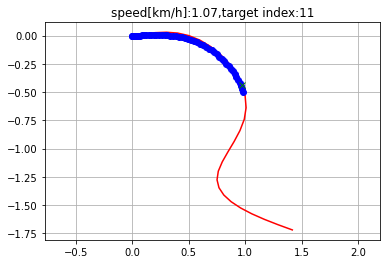

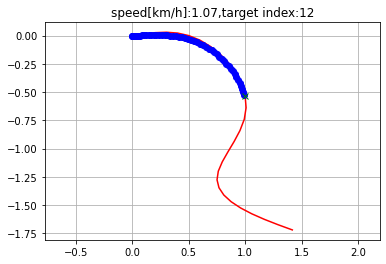

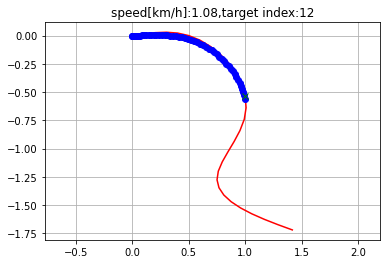

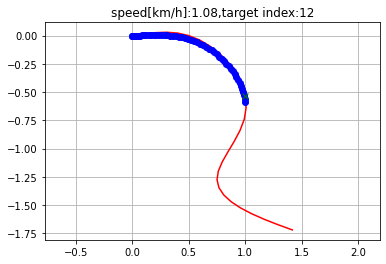

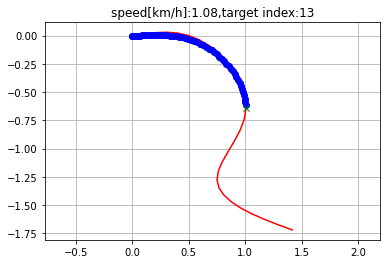

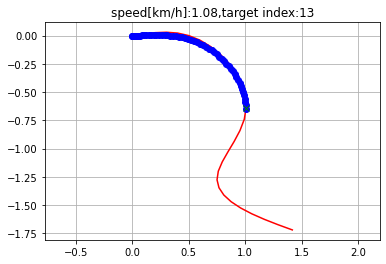

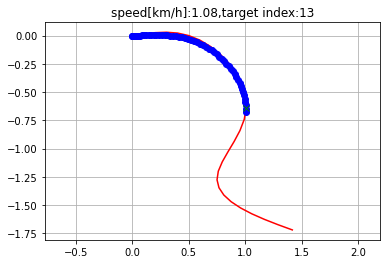

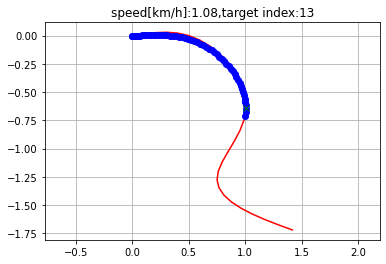

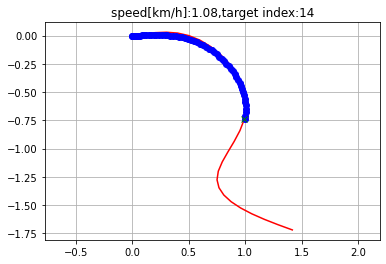

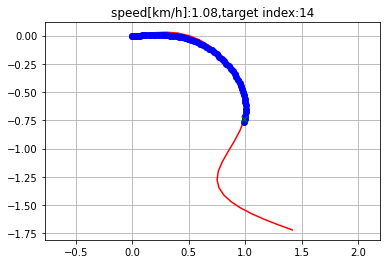

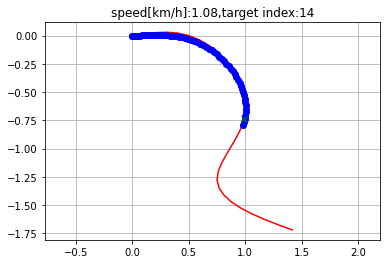

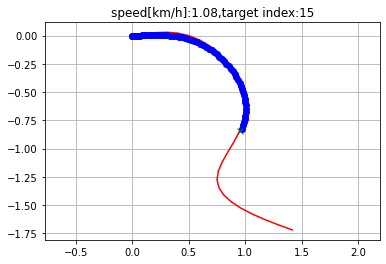

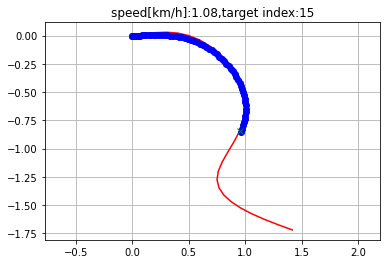

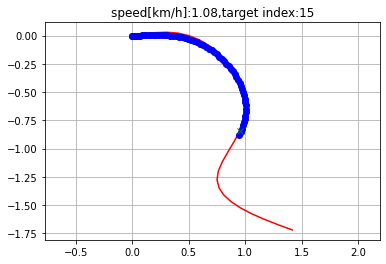

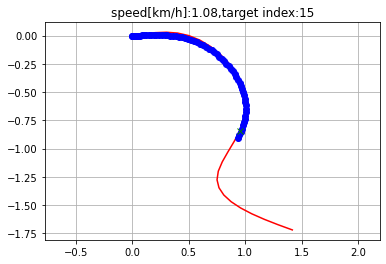

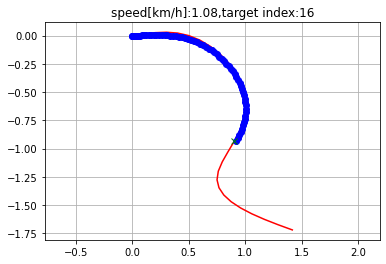

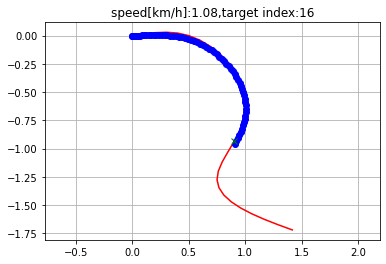

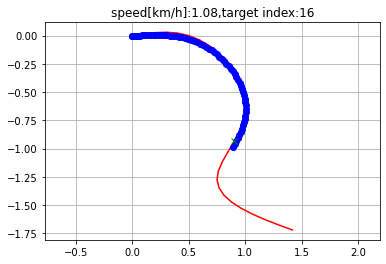

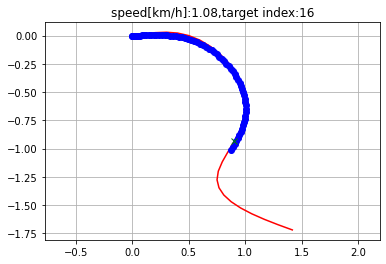

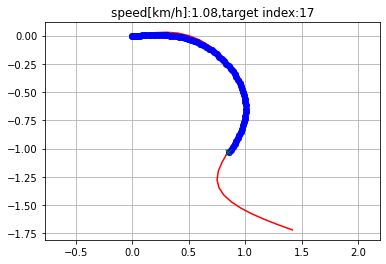

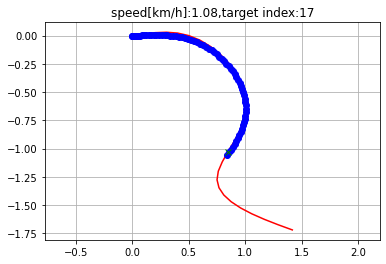

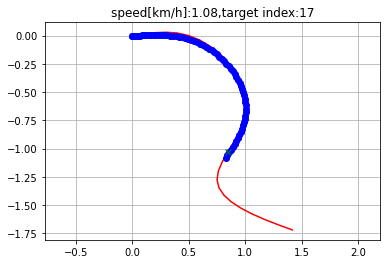

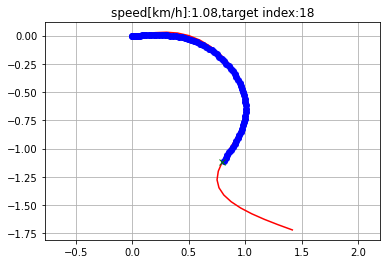

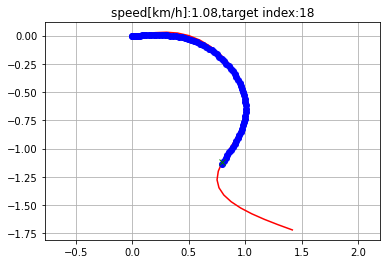

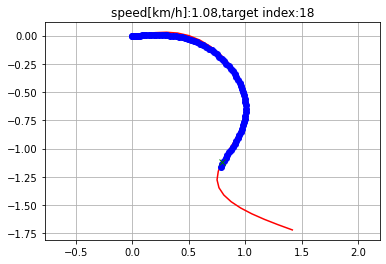

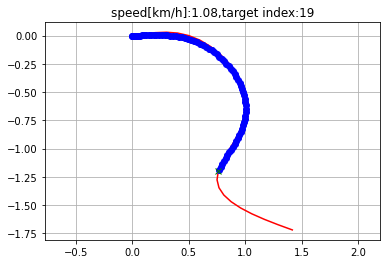

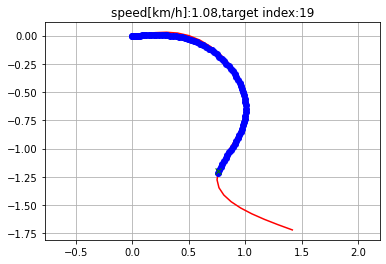

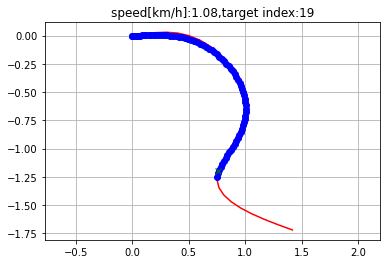

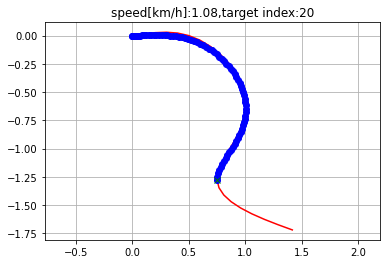

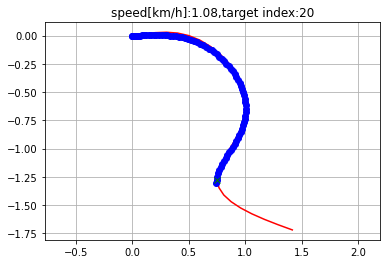

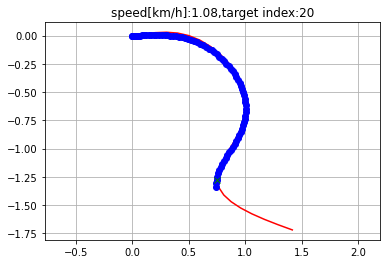

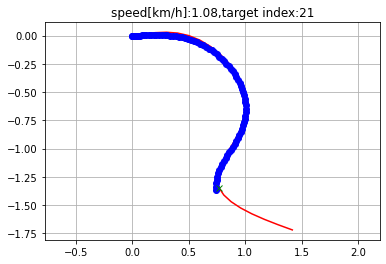

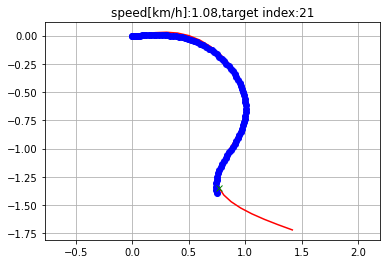

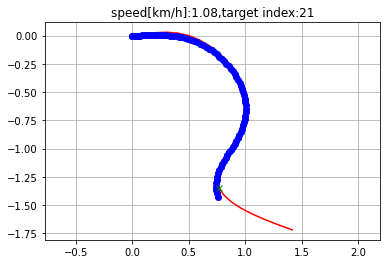

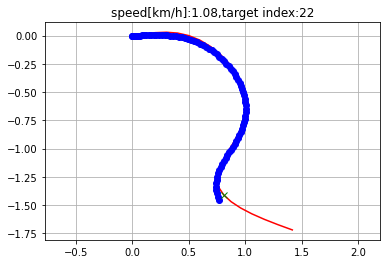

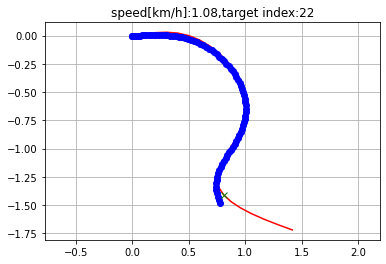

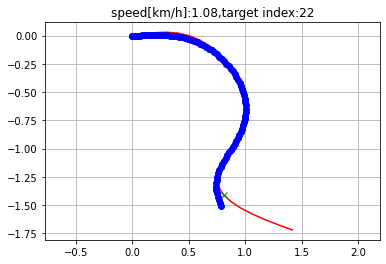

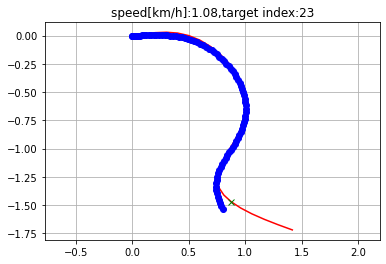

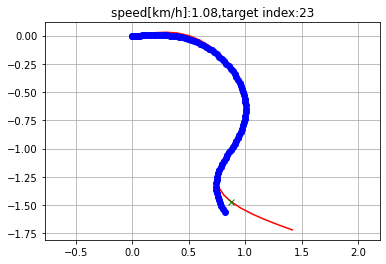

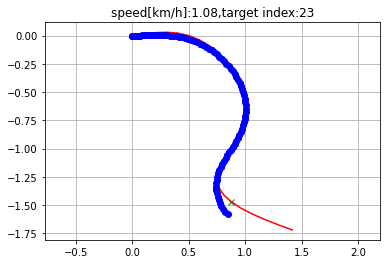

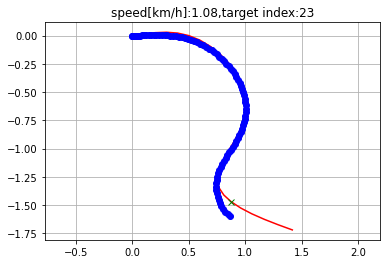

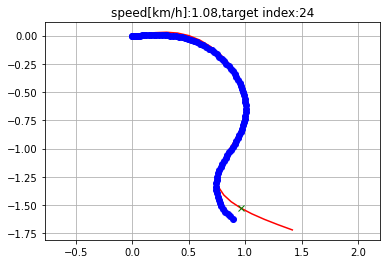

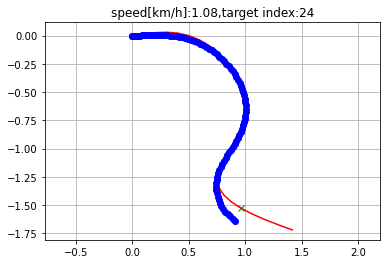

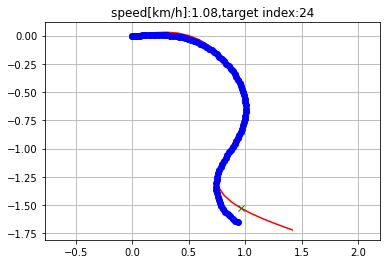

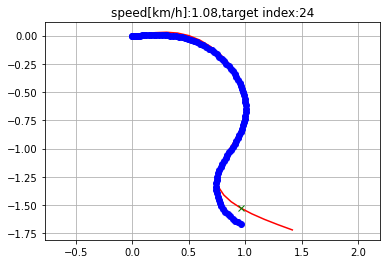

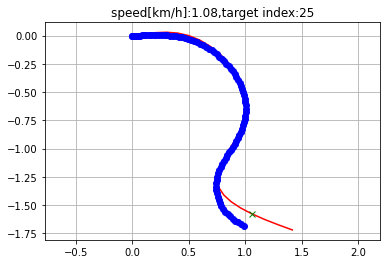

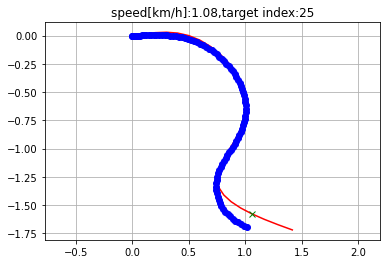

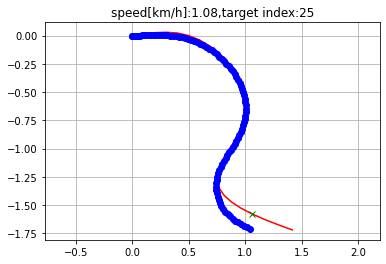

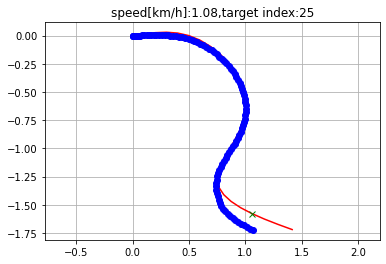

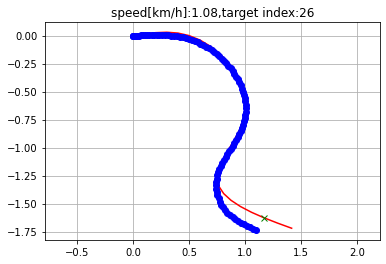

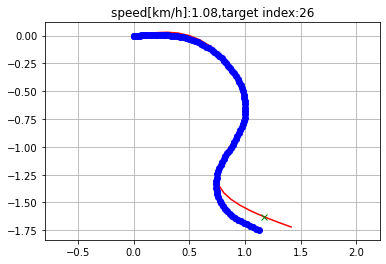

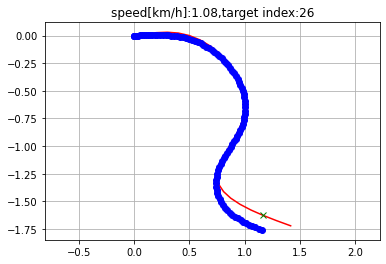

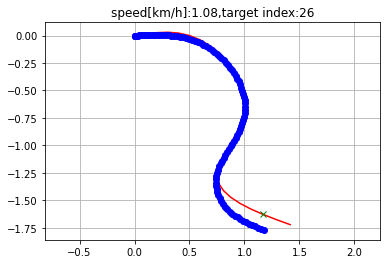

Goal


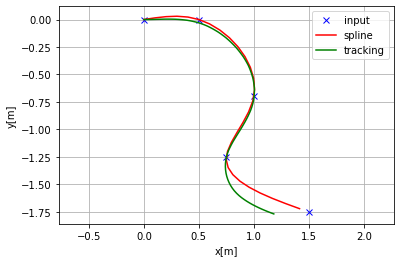

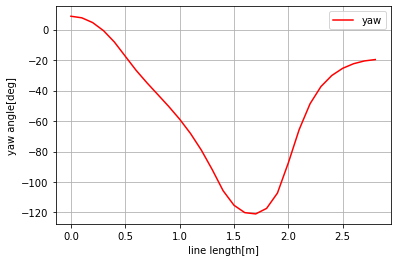

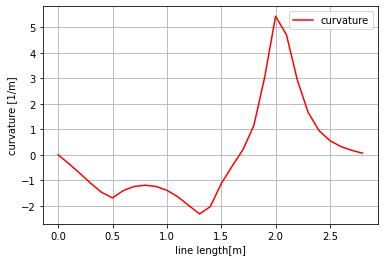

In [8]:
    ax = [0.0, 0.5, 1.0, 0.75, 1.5]
    ay = [0.0, 0.0, -0.7, -1.25, -1.75]
    goal = [ax[-1], ay[-1]]

    cx, cy, cyaw, ck, s = cubic_spline_planner.calc_spline_course(
        ax, ay, ds=0.1)
    target_speed = 0.3  # simulation parameter km/h -> m/s

    sp = calc_speed_profile(cx, cy, cyaw, target_speed)

    t, x, y, yaw, v = closed_loop_prediction(cx, cy, cyaw, ck, sp, goal)

    if show_animation:  # pragma: no cover
        plt.close()
        plt.subplots(1)
        plt.plot(ax, ay, "xb", label="input")
        plt.plot(cx, cy, "-r", label="spline")
        plt.plot(x, y, "-g", label="tracking")
        plt.grid(True)
        plt.axis("equal")
        plt.xlabel("x[m]")
        plt.ylabel("y[m]")
        plt.legend()

        plt.subplots(1)
        plt.plot(s, [np.rad2deg(iyaw) for iyaw in cyaw], "-r", label="yaw")
        plt.grid(True)
        plt.legend()
        plt.xlabel("line length[m]")
        plt.ylabel("yaw angle[deg]")

        plt.subplots(1)
        plt.plot(s, ck, "-r", label="curvature")
        plt.grid(True)
        plt.legend()
        plt.xlabel("line length[m]")
        plt.ylabel("curvature [1/m]")

        plt.show()


In [19]:
# LQR parameter
lqr_Q = np.eye(5)
lqr_R = np.eye(2)
dt = 0.1  # time tick[s]
L = 0.5  # Wheel base of the vehicle [m]
max_steer = np.deg2rad(65.0)  # maximum steering angle[rad]

show_animation = True


class State:

    def __init__(self, x=0.0, y=0.0, yaw=0.0, v=0.0):
        self.x = x
        self.y = y
        self.yaw = yaw
        self.v = v


def update(state, a, delta):

    if delta >= max_steer:
        delta = max_steer
    if delta <= - max_steer:
        delta = - max_steer

    state.x = state.x + state.v * math.cos(state.yaw) * dt
    state.y = state.y + state.v * math.sin(state.yaw) * dt
    state.yaw = state.yaw + state.v / L * math.tan(delta) * dt
    state.v = state.v + a * dt

    return state


def pi_2_pi(angle):
    return (angle + math.pi) % (2 * math.pi) - math.pi


def solve_dare(A, B, Q, R):
    """
    solve a discrete time_Algebraic Riccati equation (DARE)
    """
    x = Q
    x_next = Q
    max_iter = 150
    eps = 0.01

    for i in range(max_iter):
        x_next = A.T @ x @ A - A.T @ x @ B @ \
                 la.inv(R + B.T @ x @ B) @ B.T @ x @ A + Q
        if (abs(x_next - x)).max() < eps:
            break
        x = x_next

    return x_next


def dlqr(A, B, Q, R):
    """Solve the discrete time lqr controller.
    x[k+1] = A x[k] + B u[k]
    cost = sum x[k].T*Q*x[k] + u[k].T*R*u[k]
    # ref Bertsekas, p.151
    """

    # first, try to solve the ricatti equation
    X = solve_dare(A, B, Q, R)

    # compute the LQR gain
    K = la.inv(B.T @ X @ B + R) @ (B.T @ X @ A)

    eig_result = la.eig(A - B @ K)

    return K, X, eig_result[0]


def lqr_speed_steering_control(state, cx, cy, cyaw, ck, pe, pth_e, sp, Q, R):
    ind, e = calc_nearest_index(state, cx, cy, cyaw)

    tv = sp[ind]

    k = ck[ind]
    v = state.v
    th_e = pi_2_pi(state.yaw - cyaw[ind])

    # A = [1.0, dt, 0.0, 0.0, 0.0
    #      0.0, 0.0, v, 0.0, 0.0]
    #      0.0, 0.0, 1.0, dt, 0.0]
    #      0.0, 0.0, 0.0, 0.0, 0.0]
    #      0.0, 0.0, 0.0, 0.0, 1.0]
    A = np.zeros((5, 5))
    A[0, 0] = 1.0
    A[0, 1] = dt
    A[1, 2] = v
    A[2, 2] = 1.0
    A[2, 3] = dt
    A[4, 4] = 1.0

    # B = [0.0, 0.0
    #     0.0, 0.0
    #     0.0, 0.0
    #     v/L, 0.0
    #     0.0, dt]
    B = np.zeros((5, 2))
    B[3, 0] = v / L
    B[4, 1] = dt

    K, _, _ = dlqr(A, B, Q, R)

    # state vector
    # x = [e, dot_e, th_e, dot_th_e, delta_v]
    # e: lateral distance to the path
    # dot_e: derivative of e
    # th_e: angle difference to the path
    # dot_th_e: derivative of th_e
    # delta_v: difference between current speed and target speed
    x = np.zeros((5, 1))
    x[0, 0] = e
    x[1, 0] = (e - pe) / dt
    x[2, 0] = th_e
    x[3, 0] = (th_e - pth_e) / dt
    x[4, 0] = v - tv

    # input vector
    # u = [delta, accel]
    # delta: steering angle
    # accel: acceleration
    ustar = -K @ x

    # calc steering input
    ff = math.atan2(L * k, 1)  # feedforward steering angle
    fb = pi_2_pi(ustar[0, 0])  # feedback steering angle
    delta = ff + fb

    # calc accel input
    accel = ustar[1, 0]

    return delta, ind, e, th_e, accel


def calc_nearest_index(state, cx, cy, cyaw):
    dx = [state.x - icx for icx in cx]
    dy = [state.y - icy for icy in cy]

    d = [idx ** 2 + idy ** 2 for (idx, idy) in zip(dx, dy)]

    mind = min(d)

    ind = d.index(mind)

    mind = math.sqrt(mind)

    dxl = cx[ind] - state.x
    dyl = cy[ind] - state.y

    angle = pi_2_pi(cyaw[ind] - math.atan2(dyl, dxl))
    if angle < 0:
        mind *= -1

    return ind, mind


def do_simulation(cx, cy, cyaw, ck, speed_profile, goal):
    T = 500.0  # max simulation time
    goal_dis = 0.1
    stop_speed = 0.05

    state = State(x=-0.0, y=-0.0, yaw=0.0, v=0.0)

    time = 0.0
    x = [state.x]
    y = [state.y]
    yaw = [state.yaw]
    v = [state.v]
    t = [0.0]

    e, e_th = 0.0, 0.0

    while T >= time:
        dl, target_ind, e, e_th, ai = lqr_speed_steering_control(
            state, cx, cy, cyaw, ck, e, e_th, speed_profile, lqr_Q, lqr_R)

        state = update(state, ai, dl)

        if abs(state.v) <= stop_speed:
            target_ind += 1

        time = time + dt

        # check goal
        dx = state.x - goal[0]
        dy = state.y - goal[1]
        if math.hypot(dx, dy) <= goal_dis:
            print("Goal")
            break

        x.append(state.x)
        y.append(state.y)
        yaw.append(state.yaw)
        v.append(state.v)
        t.append(time)

        if target_ind % 1 == 0 and show_animation:
            plt.cla()
            # for stopping simulation with the esc key.
            plt.gcf().canvas.mpl_connect('key_release_event',
                    lambda event: [exit(0) if event.key == 'escape' else None])
            plt.plot(cx, cy, "-r", label="course")
            plt.plot(x, y, "ob", label="trajectory")
            plt.plot(cx[target_ind], cy[target_ind], "xg", label="target")
            plt.axis("equal")
            plt.grid(True)
            plt.title("speed[km/h]:" + str(round(state.v * 3.6, 2))
                      + ",target index:" + str(target_ind))
            plt.pause(0.0001)

    return t, x, y, yaw, v


def calc_speed_profile(cyaw, target_speed):
    speed_profile = [target_speed] * len(cyaw)

    direction = 1.0

    # Set stop point
    for i in range(len(cyaw) - 1):
        dyaw = abs(cyaw[i + 1] - cyaw[i])
        switch = math.pi / 4.0 <= dyaw < math.pi / 2.0

        if switch:
            direction *= -1

        if direction != 1.0:
            speed_profile[i] = - target_speed
        else:
            speed_profile[i] = target_speed

        if switch:
            speed_profile[i] = 0.0

    # speed down
    for i in range(40):
        speed_profile[-i] = target_speed / (50 - i)
        if speed_profile[-i] <= 1.0 / 3.6:
            speed_profile[-i] = 1.0 / 3.6

    return speed_profile

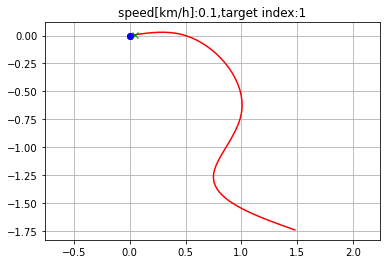

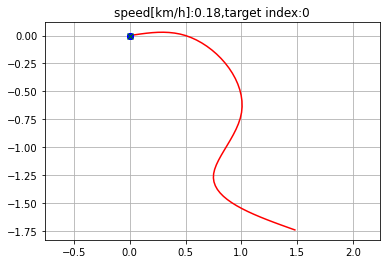

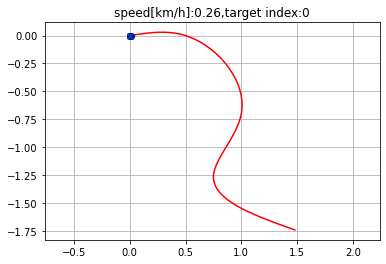

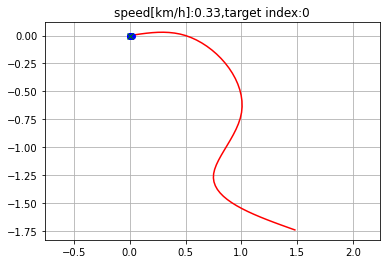

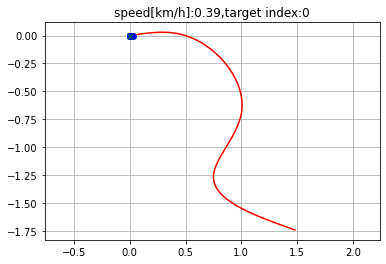

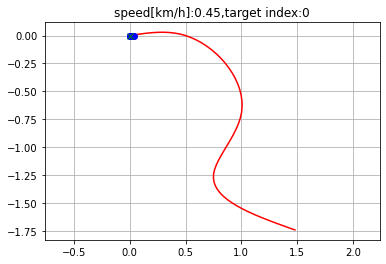

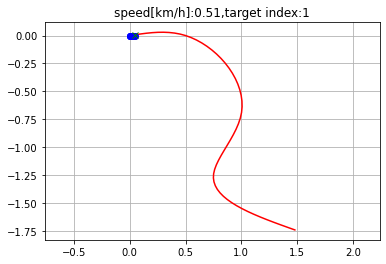

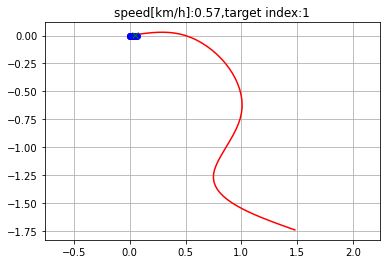

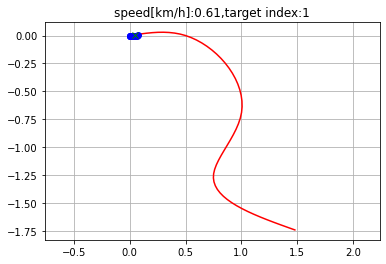

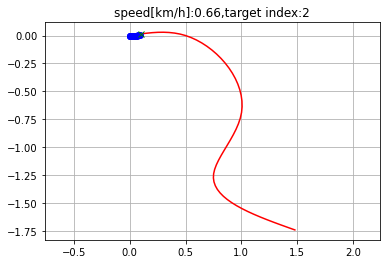

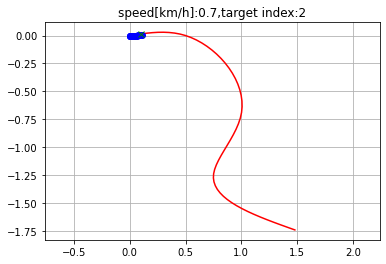

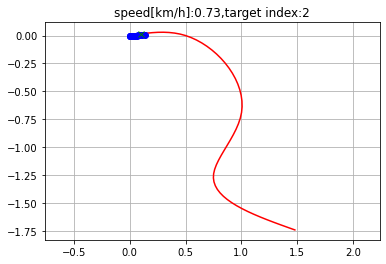

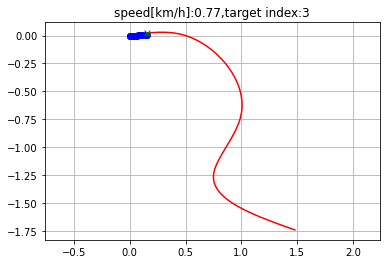

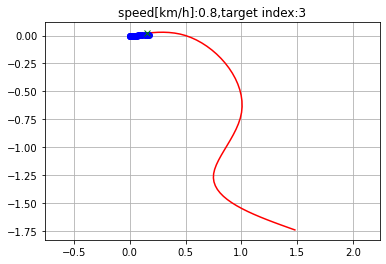

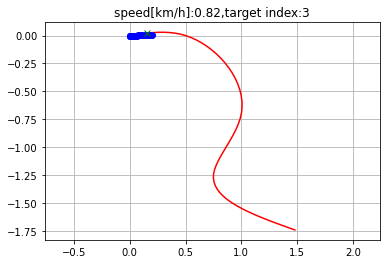

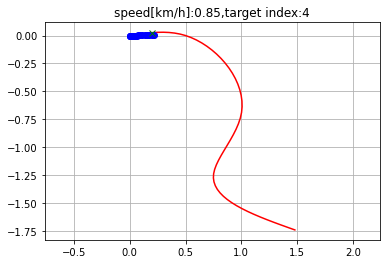

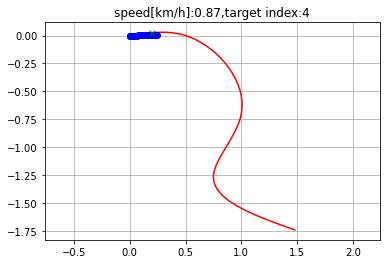

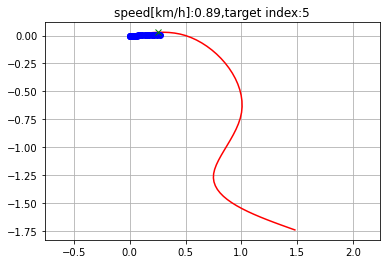

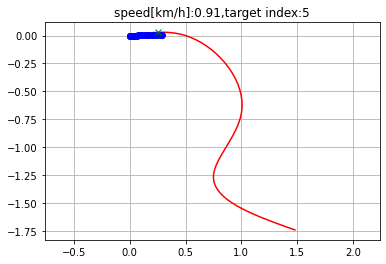

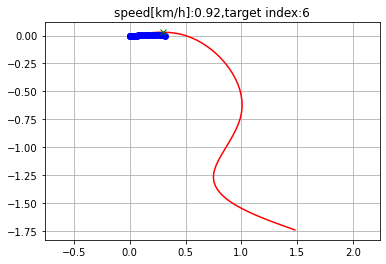

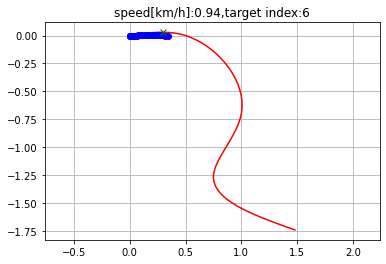

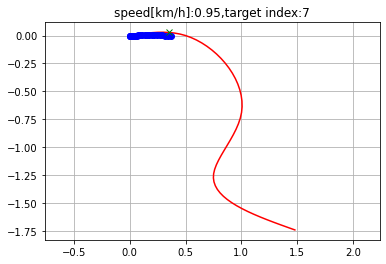

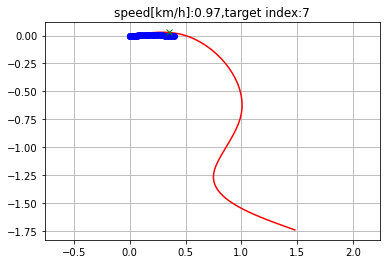

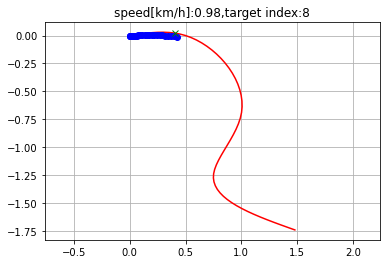

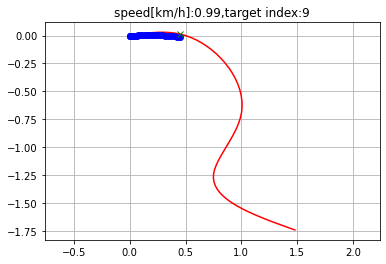

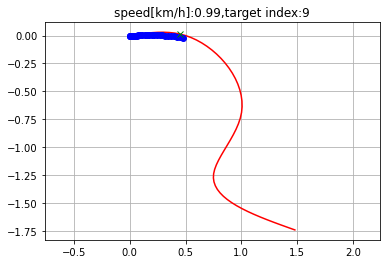

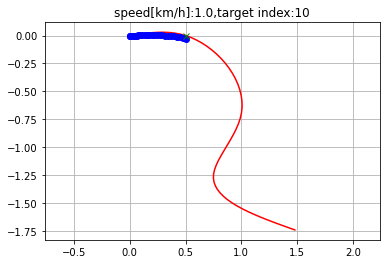

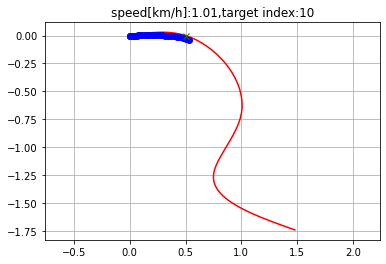

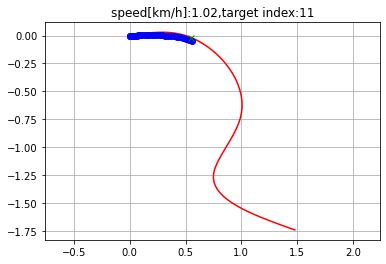

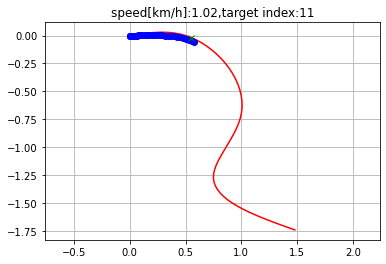

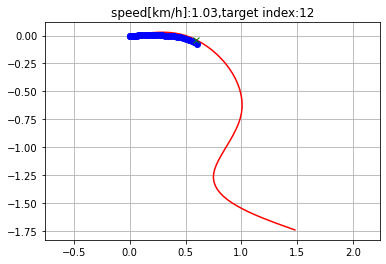

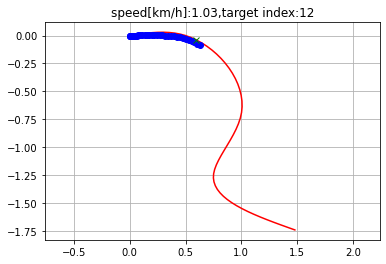

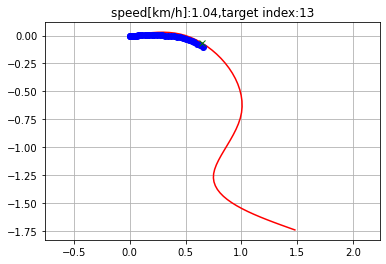

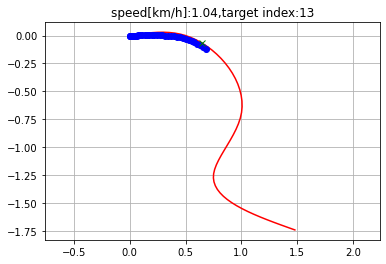

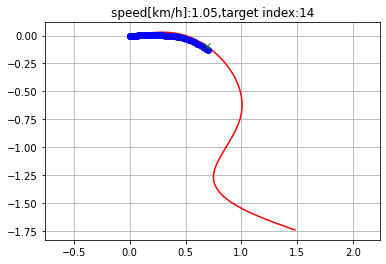

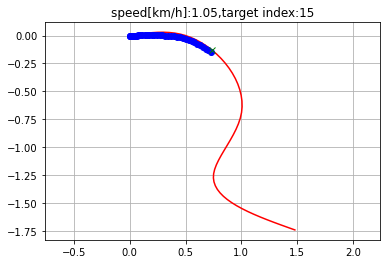

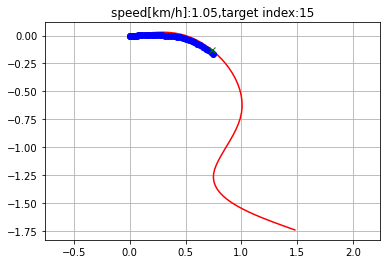

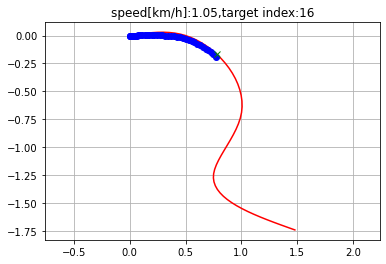

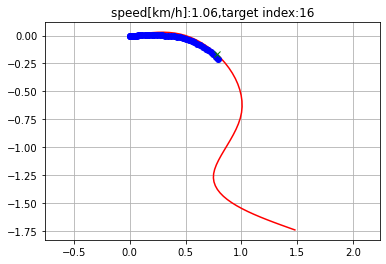

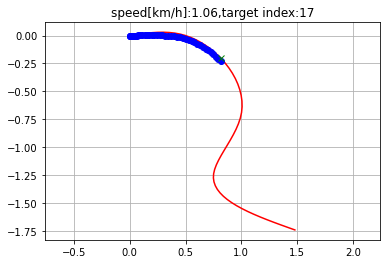

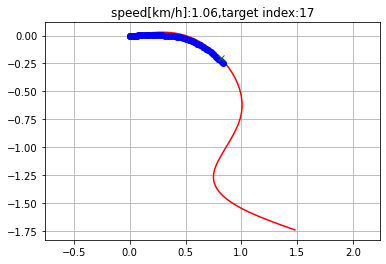

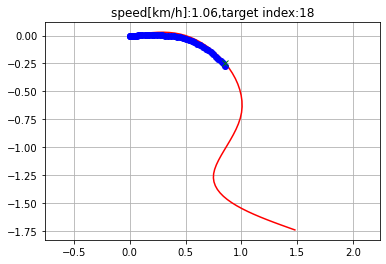

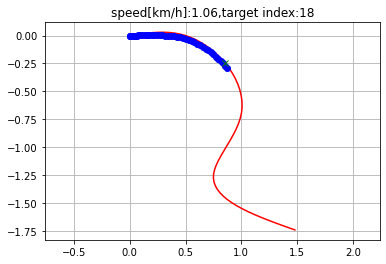

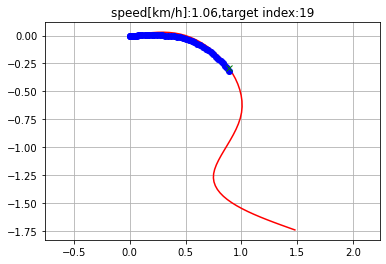

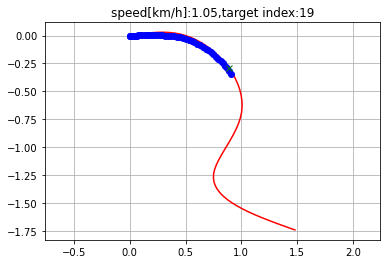

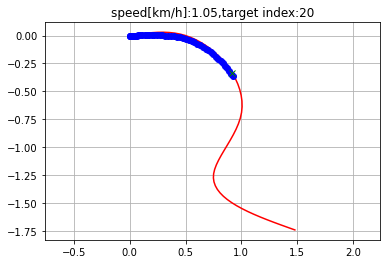

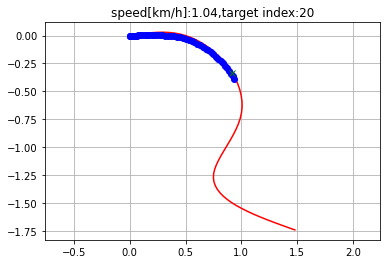

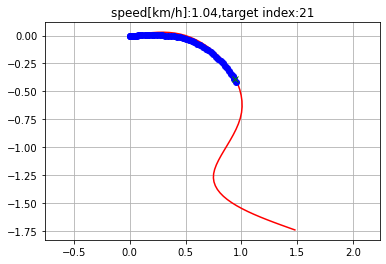

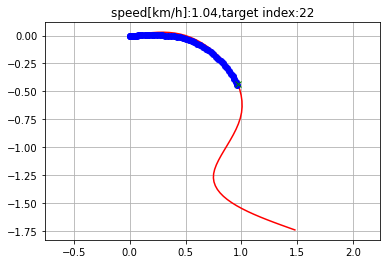

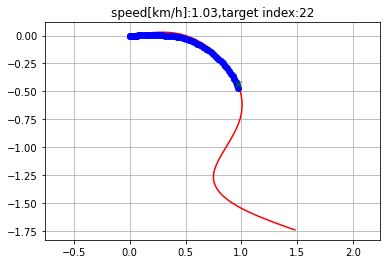

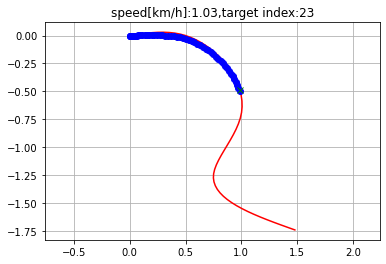

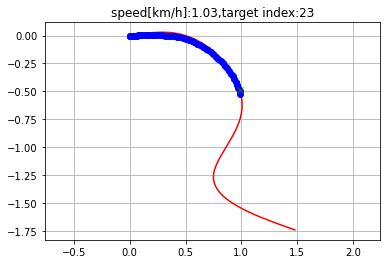

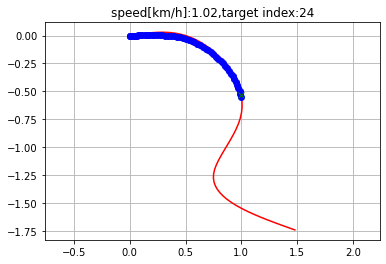

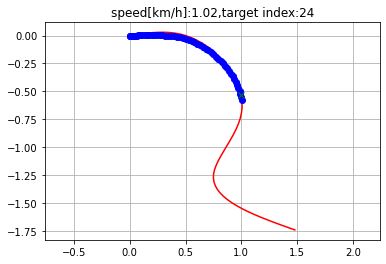

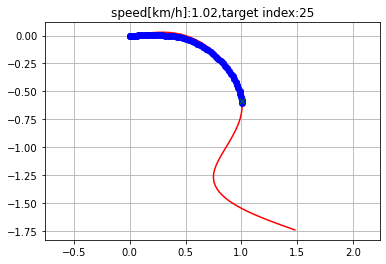

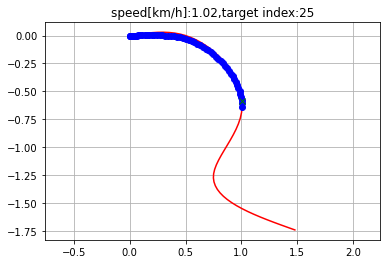

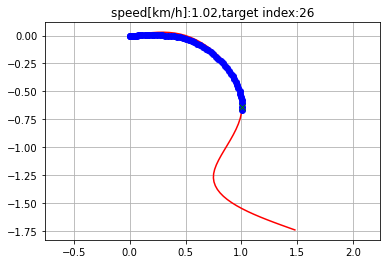

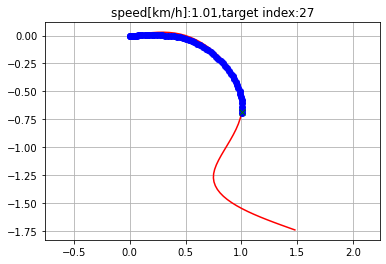

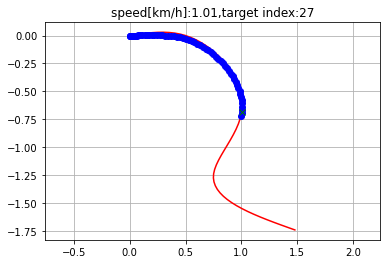

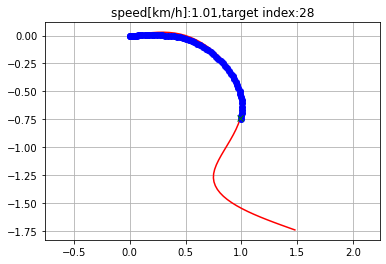

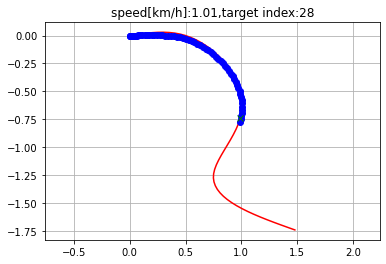

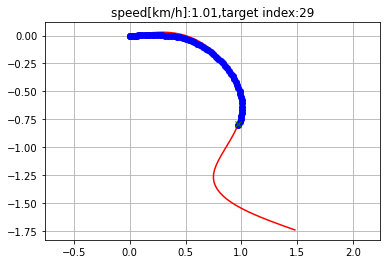

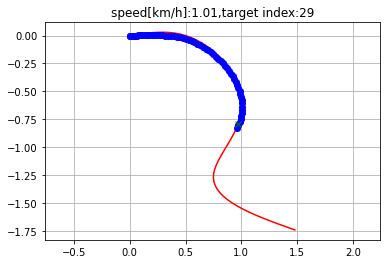

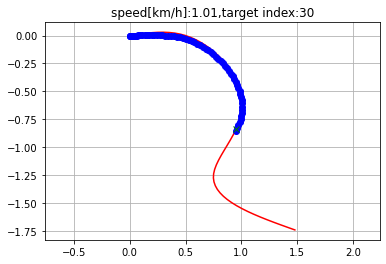

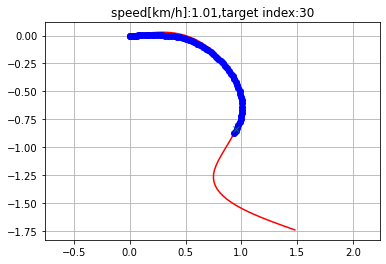

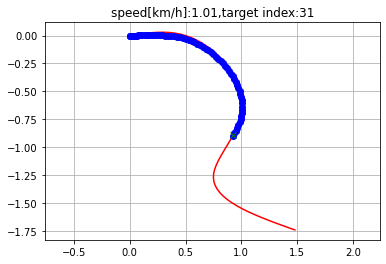

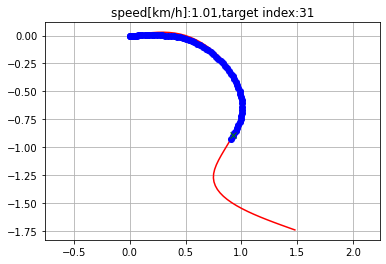

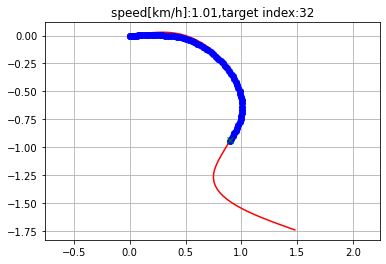

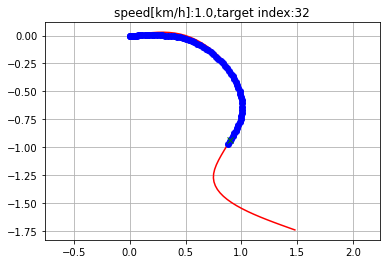

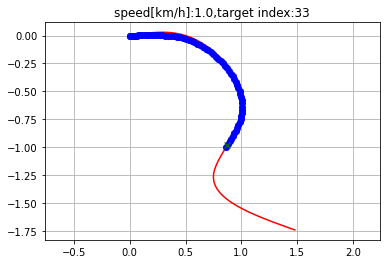

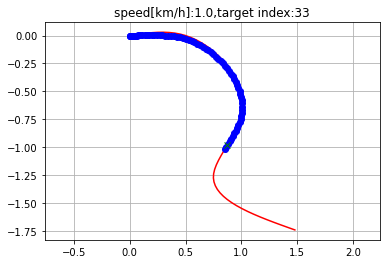

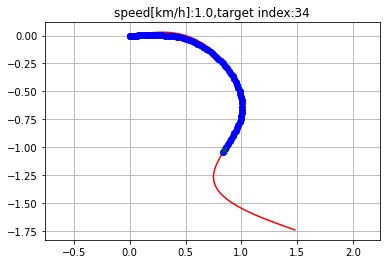

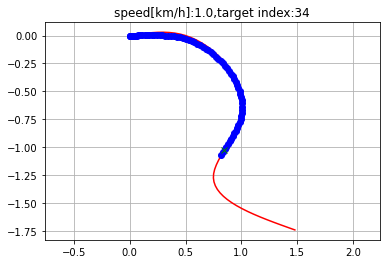

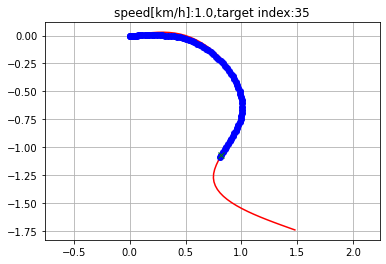

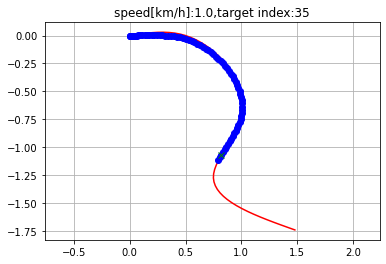

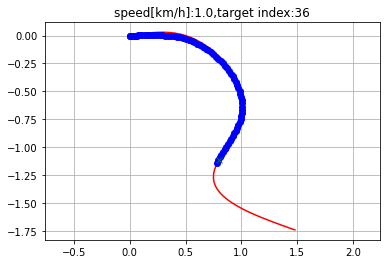

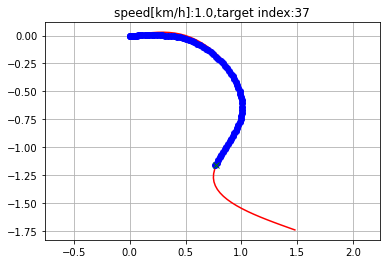

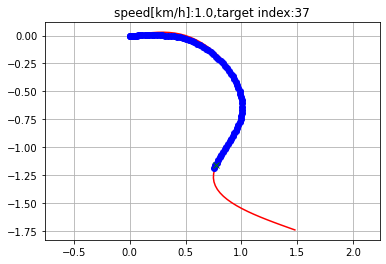

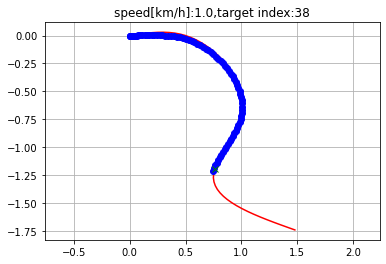

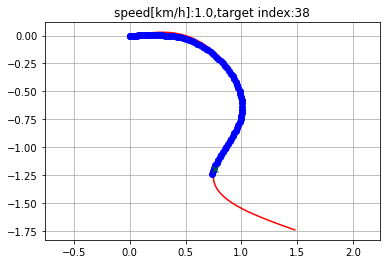

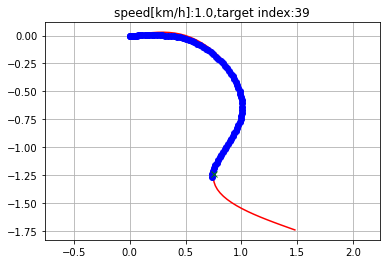

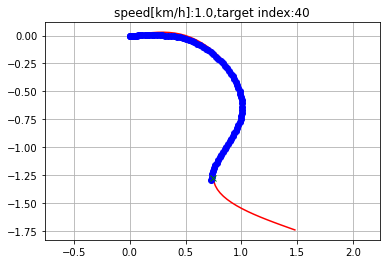

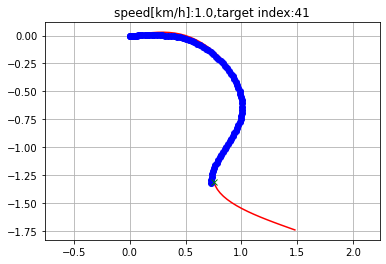

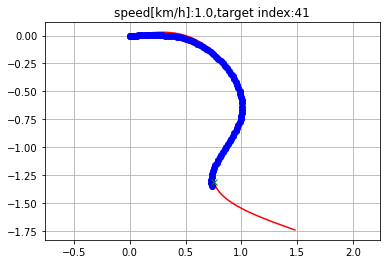

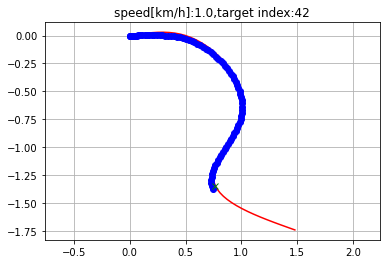

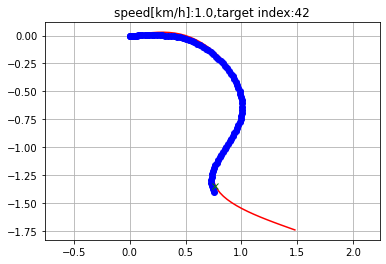

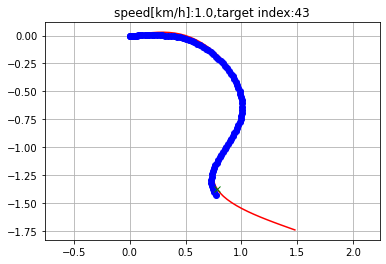

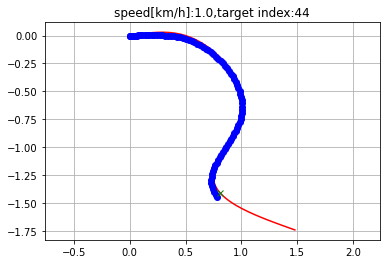

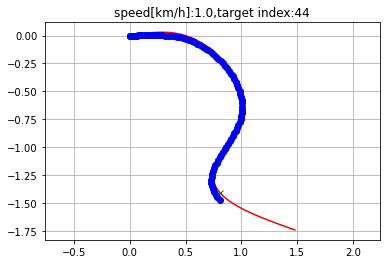

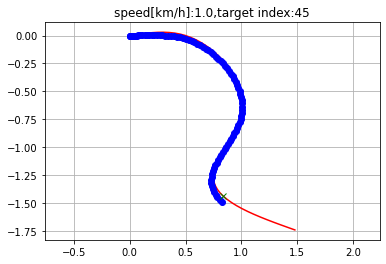

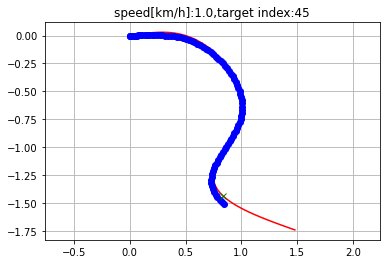

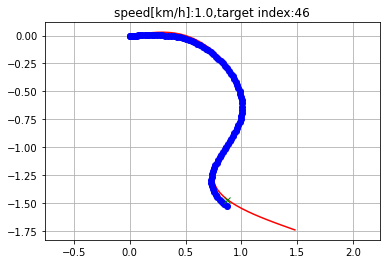

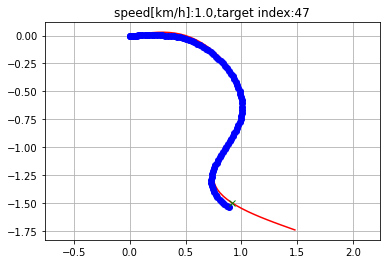

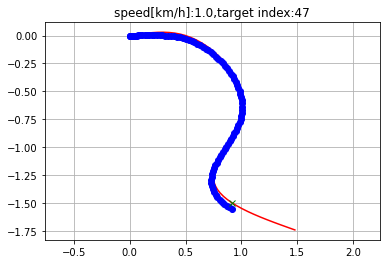

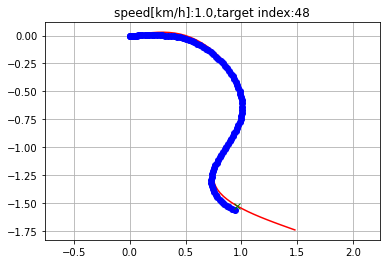

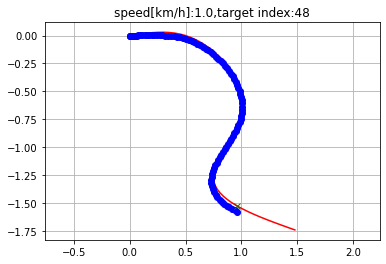

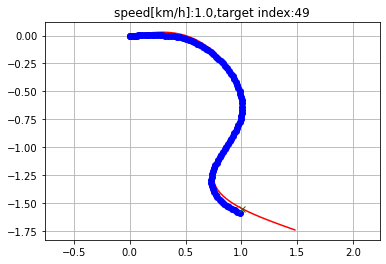

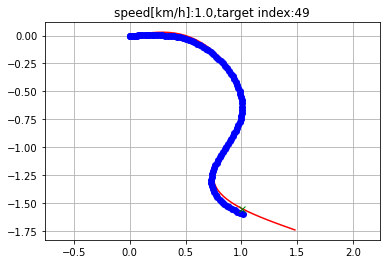

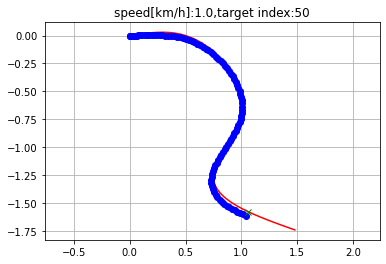

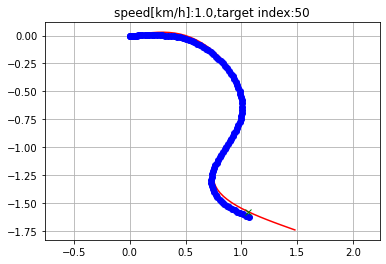

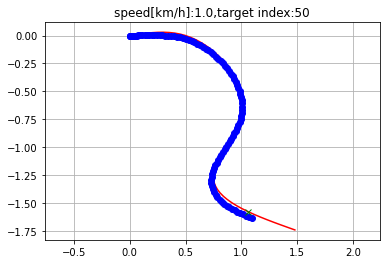

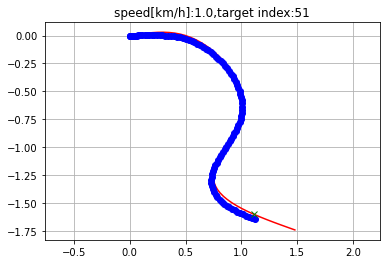

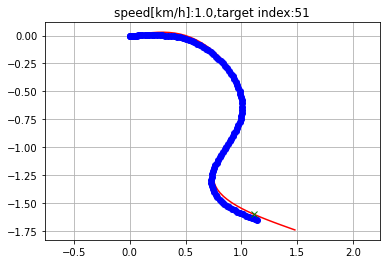

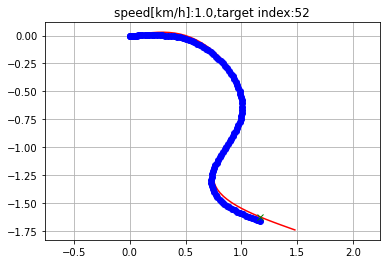

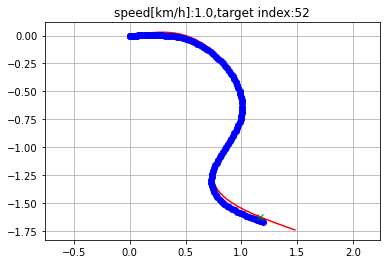

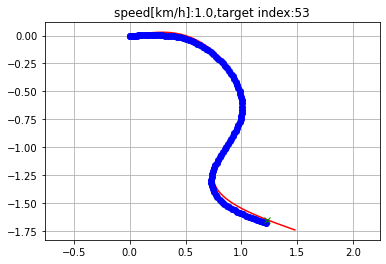

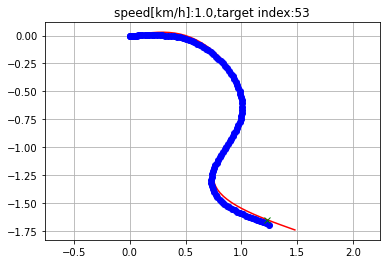

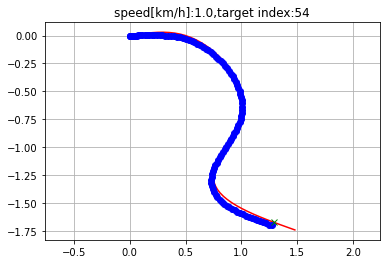

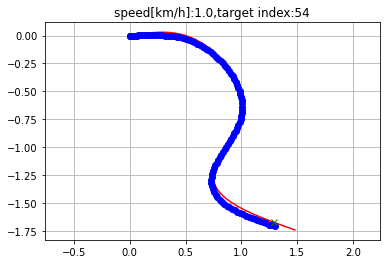

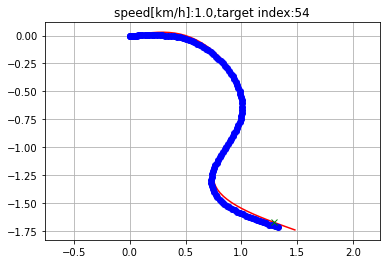

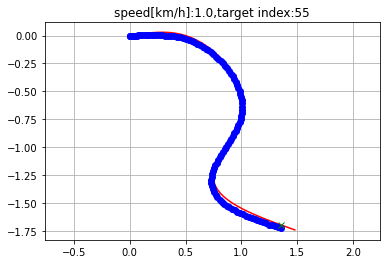

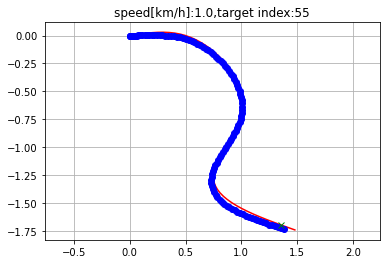

Goal


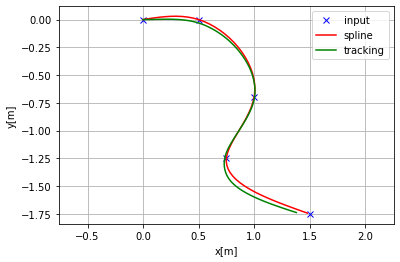

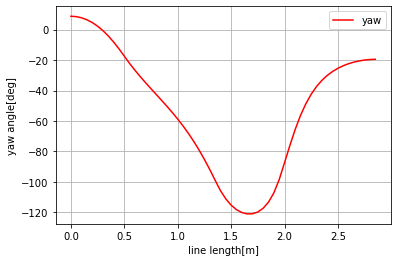

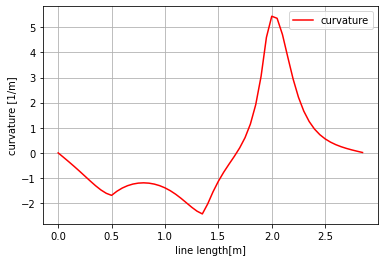

In [20]:
    ax = [0.0, 0.5, 1.0, 0.75, 1.5]
    ay = [0.0, 0.0, -0.7, -1.25, -1.75]
    goal = [ax[-1], ay[-1]]

    cx, cy, cyaw, ck, s = cubic_spline_planner.calc_spline_course(
        ax, ay, ds=0.05)
    target_speed = 0.3  # simulation parameter km/h -> m/s

    sp = calc_speed_profile(cyaw, target_speed)
    t, x, y, yaw, v = do_simulation(cx, cy, cyaw, ck, sp, goal)

    if show_animation:  # pragma: no cover
        plt.close()
        plt.subplots(1)
        plt.plot(ax, ay, "xb", label="input")
        plt.plot(cx, cy, "-r", label="spline")
        plt.plot(x, y, "-g", label="tracking")
        plt.grid(True)
        plt.axis("equal")
        plt.xlabel("x[m]")
        plt.ylabel("y[m]")
        plt.legend()

        plt.subplots(1)
        plt.plot(s, [np.rad2deg(iyaw) for iyaw in cyaw], "-r", label="yaw")
        plt.grid(True)
        plt.legend()
        plt.xlabel("line length[m]")
        plt.ylabel("yaw angle[deg]")

        plt.subplots(1)
        plt.plot(s, ck, "-r", label="curvature")
        plt.grid(True)
        plt.legend()
        plt.xlabel("line length[m]")
        plt.ylabel("curvature [1/m]")

        plt.show()

In [166]:
ax = [ee517.curr_state.x, ee517.curr_state.x+0.5, ee517.curr_state.x+1, ee517.curr_state.x+0.75,ee517.curr_state.x+1.5]
ay = [ee517.curr_state.y, ee517.curr_state.y, ee517.curr_state.y-0.7, ee517.curr_state.y-1.25,ee517.curr_state.y-1.75]
goal = [ax[-1], ay[-1]]
#path = rospy.wait_for_message("/move_base/NavfnROS/plan", Path)
goal

ax_temp = np.array(ax)-ee517.curr_state.x
ay_temp = np.array(ay)-ee517.curr_state.y

In [167]:
cx, cy, cyaw, ck, s = cubic_spline_planner.calc_spline_course(
        ax, ay, ds=0.03)
target_speed = 0.2
speed_profile = calc_speed_profile(cx,cy,cyaw,target_speed)

Kp = 1.0  # speed proportional gain

# LQR parameter
Q = np.eye(4)
R = np.eye(1)

# parameters
dt = 0.1  # time tick[s]
L = 0.5  # Wheel base of the vehicle [m]
max_steer = np.deg2rad(45.0)  # maximum steering angle[rad]

In [168]:
ai, dl, t, x, y, yaw,v, vel_x, vel_y = ee517.closed_loop_prediction(cx, cy, cyaw, ck, speed_profile, goal)
ee517.cmd_vel_publisher.publish(Twist())

linear: 
  x: 0.2
  y: 0.0
  z: 0.0
angular: 
  x: 0.0
  y: 0.0
  z: 0.0
linear: 
  x: 0.2
  y: 0.0
  z: 0.0
angular: 
  x: 0.0
  y: 0.0
  z: 0.0
linear: 
  x: 0.2
  y: 0.0
  z: 0.0
angular: 
  x: 0.0
  y: 0.0
  z: 0.0
linear: 
  x: 0.2
  y: 0.0
  z: 0.0
angular: 
  x: 0.0
  y: 0.0
  z: 0.0
linear: 
  x: 0.2
  y: 0.0
  z: 0.0
angular: 
  x: 0.0
  y: 0.0
  z: 0.0
linear: 
  x: 0.2
  y: 0.0
  z: 0.0
angular: 
  x: 0.0
  y: 0.0
  z: 0.0
linear: 
  x: 0.2
  y: 0.0
  z: 0.0
angular: 
  x: 0.0
  y: 0.0
  z: 0.0
linear: 
  x: 0.2
  y: 0.0
  z: 0.0
angular: 
  x: 0.0
  y: 0.0
  z: 0.0
linear: 
  x: 0.2
  y: 0.0
  z: 0.0
angular: 
  x: 0.0
  y: 0.0
  z: 0.0
linear: 
  x: 0.2
  y: 0.0
  z: 0.0
angular: 
  x: 0.0
  y: 0.0
  z: 0.0
linear: 
  x: 0.19972221614413363
  y: -0.010537380057489582
  z: 0.0
angular: 
  x: 0.0
  y: 0.0
  z: -0.00527113064644626
linear: 
  x: 0.19972221614413363
  y: -0.010537380057489582
  z: 0.0
angular: 
  x: 0.0
  y: 0.0
  z: -0.00527113064644626
linear: 
  x: 0.199722

linear: 
  x: 0.17454983875365593
  y: -0.09763377382377839
  z: 0.0
angular: 
  x: 0.0
  y: 0.0
  z: -0.05099904006940745
linear: 
  x: 0.17454983875365593
  y: -0.09763377382377839
  z: 0.0
angular: 
  x: 0.0
  y: 0.0
  z: -0.05099904006940745
linear: 
  x: 0.17454983875365593
  y: -0.09763377382377839
  z: 0.0
angular: 
  x: 0.0
  y: 0.0
  z: -0.05099904006940745
linear: 
  x: 0.17454983875365593
  y: -0.09763377382377839
  z: 0.0
angular: 
  x: 0.0
  y: 0.0
  z: -0.05099904006940745
linear: 
  x: 0.17454983875365593
  y: -0.09763377382377839
  z: 0.0
angular: 
  x: 0.0
  y: 0.0
  z: -0.05099904006940745
linear: 
  x: 0.17454983875365593
  y: -0.09763377382377839
  z: 0.0
angular: 
  x: 0.0
  y: 0.0
  z: -0.05099904006940745
linear: 
  x: 0.1788211183142987
  y: -0.0895712434033579
  z: 0.0
angular: 
  x: 0.0
  y: 0.0
  z: -0.04643662108575237
linear: 
  x: 0.1788211183142987
  y: -0.0895712434033579
  z: 0.0
angular: 
  x: 0.0
  y: 0.0
  z: -0.04643662108575237
linear: 
  x: 0.1788

In [161]:
dl

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.05271130646446255,
 -0.05271130646446255,
 -0.10543538470463738,
 -0.10543538470463738,
 -0.15815730512366524,
 -0.15815730512366524,
 -0.21080812734541224,
 -0.21080812734541224,
 -0.2632416120665256,
 -0.2632416120665256,
 -0.31521593576918827,
 -0.31521593576918827,
 -0.31521593576918827,
 -0.36638263201193216,
 -0.36638263201193216,
 -0.4162848416338097,
 -0.4162848416338097,
 -0.4162848416338097,
 -0.46436621085752333,
 -0.46436621085752333,
 -0.46436621085752333,
 -0.5099904006940739,
 -0.5099904006940739,
 -0.5099904006940739,
 -0.5099904006940739,
 -0.5099904006940739,
 -0.5524694198842841,
 -0.5524694198842841,
 -0.5524694198842841,
 -0.5524694198842841,
 -0.5524694198842841,
 -0.5524694198842841,
 -0.5524694198842841,
 -0.5524694198842841,
 -0.5524694198842841,
 -0.5910973868623969,
 -0.5910973868623969,
 -0.5910973868623969,
 -0.5910973868623969,
 -0.5910973868623969,
 -0.5910973868623969,
 -0.5910973868623969,


In [50]:
def PIDControl(target, current):
    a = Kp * (target - current)

    return a


def pi_2_pi(angle):
    return (angle + math.pi) % (2 * math.pi) - math.pi


def solve_DARE(A, B, Q, R):
    """
    solve a discrete time_Algebraic Riccati equation (DARE)
    """
    X = Q
    maxiter = 150
    eps = 0.01

    for i in range(maxiter):
        Xn = A.T @ X @ A - A.T @ X @ B @ \
            la.inv(R + B.T @ X @ B) @ B.T @ X @ A + Q
        if (abs(Xn - X)).max() < eps:
            break
        X = Xn

    return Xn


def dlqr(A, B, Q, R):
    """Solve the discrete time lqr controller.
    x[k+1] = A x[k] + B u[k]
    cost = sum x[k].T*Q*x[k] + u[k].T*R*u[k]
    # ref Bertsekas, p.151
    """

    # first, try to solve the ricatti equation
    X = solve_DARE(A, B, Q, R)

    # compute the LQR gain
    K = la.inv(B.T @ X @ B + R) @ (B.T @ X @ A)

    eigVals, eigVecs = la.eig(A - B @ K)

    return K, X, eigVals


def lqr_steering_control(state, cx, cy, cyaw, ck, pe, pth_e):
    ind, e = calc_nearest_index(state, cx, cy, cyaw)

    k = ck[ind]
    v = state.v
    th_e = pi_2_pi(state.yaw - cyaw[ind])

    A = np.zeros((4, 4))
    A[0, 0] = 1.0
    A[0, 1] = dt
    A[1, 2] = v
    A[2, 2] = 1.0
    A[2, 3] = dt
    # print(A)

    B = np.zeros((4, 1))
    B[3, 0] = v / L

    K, _, _ = dlqr(A, B, Q, R)

    x = np.zeros((4, 1))

    x[0, 0] = e
    x[1, 0] = (e - pe) / dt
    x[2, 0] = th_e
    x[3, 0] = (th_e - pth_e) / dt

    ff = math.atan2(L * k, 1)
    fb = pi_2_pi((-K @ x)[0, 0])

    delta = ff + fb

    return delta, ind, e, th_e


def calc_nearest_index(state, cx, cy, cyaw):
    dx = [state.x - icx for icx in cx]
    dy = [state.y - icy for icy in cy]

    d = [idx ** 2 + idy ** 2 for (idx, idy) in zip(dx, dy)]

    mind = min(d)

    ind = d.index(mind)

    mind = math.sqrt(mind)

    dxl = cx[ind] - state.x
    dyl = cy[ind] - state.y

    angle = pi_2_pi(cyaw[ind] - math.atan2(dyl, dxl))
    if angle < 0:
        mind *= -1

    return ind, mind

In [9]:
for i in range(len(cy)):
    

0.010350355827955305

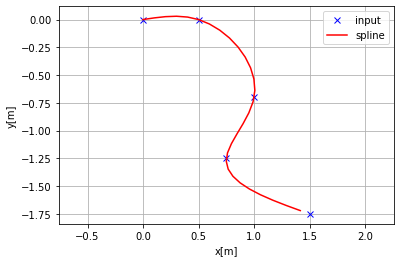

In [49]:
        plt.subplots(1)
        plt.plot(ax_temp, ay_temp, "xb", label="input")
        plt.plot(cx, cy, "-r", label="spline")
        #plt.plot(x, y, "-g", label="tracking")
        plt.grid(True)
        plt.axis("equal")
        plt.xlabel("x[m]")
        plt.ylabel("y[m]")
        plt.legend()

In [34]:
[ay,ay]

[[0.0,
  2.298598740074116,
  1.598598740074116,
  1.048598740074116,
  0.5485987400741159],
 [0.0,
  2.298598740074116,
  1.598598740074116,
  1.048598740074116,
  0.5485987400741159]]